In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import joblib


from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler


from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

from kerastuner import HyperModel, HyperParameters, RandomSearch
from tensorflow import keras


from tensorflow.keras import layers
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [3]:
from google.colab import files

uploaded = files.upload()


Saving Financial_Distress.csv to Financial_Distress.csv


In [4]:
import io
data = io.BytesIO(uploaded['Financial_Distress.csv'])

In [5]:
df = pd.read_csv(data)
df.head()

,ID,Company Name,Year,Sector,Financial Distress,Shareholder Concentration (%),Independence Indicator,CEO Duality,Board of Directors Size,Director Remuneration (£million),Corporate Borrowing,Company Age,Retained Earnings / Total Assets (£),Interest Paid / Total Assets (£)
0,1,1SPATIAL PLC,2022,Business Services,0,79.63,6,1,36,0.687,0,18,0.005040,0.005951
1,2,1SPATIAL PLC,2021,Business Services,0,79.63,6,1,36,0.714,0,18,-0.030734,0.006174
2,3,1SPATIAL PLC,2020,Business Services,0,79.63,6,1,36,0.521,0,18,-0.043072,0.006816
3,4,1SPATIAL PLC,2019,Business Services,0,79.63,6,1,36,0.564,0,18,-0.077413,0.009062
4,5,1SPATIAL PLC,2018,Business Services,0,79.63,6,1,36,0.670,0,18,-0.129682,0.009866


In [6]:
df.columns

Index(['ID', 'Company Name', 'Year', 'Sector', 'Financial Distress',
       'Shareholder Concentration (%)', 'Independence Indicator',
       'CEO Duality', 'Board of Directors Size',
       'Director Remuneration (£million)', 'Corporate Borrowing',
       'Company Age', 'Retained Earnings / Total Assets (£)',
       'Interest Paid / Total Assets (£)'],
      dtype='object')

In [7]:
df.shape

(2792, 14)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2792 entries, 0 to 2791
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ID                                    2792 non-null   int64  
 1   Company Name                          2792 non-null   object 
 2   Year                                  2792 non-null   int64  
 3   Sector                                2792 non-null   object 
 4   Financial Distress                    2792 non-null   int64  
 5   Shareholder Concentration (%)         2792 non-null   float64
 6   Independence Indicator                2792 non-null   int64  
 7   CEO Duality                           2792 non-null   int64  
 8   Board of Directors Size               2792 non-null   int64  
 9   Director Remuneration (£million)      2792 non-null   float64
 10  Corporate Borrowing                   2792 non-null   int64  
 11  Company Age      

In [9]:
df.describe()

,ID,Year,Financial Distress,Shareholder Concentration (%),Independence Indicator,CEO Duality,Board of Directors Size,Director Remuneration (£million),Corporate Borrowing,Company Age,Retained Earnings / Total Assets (£),Interest Paid / Total Assets (£)
count,2792.0000,2792.000000,2792.000000,2792.000000,2792.000000,2792.000000,2792.000000,2792.000000,2792.000000,2792.00000,2792.000000,2792.000000
mean,1396.5000,2018.500000,0.233166,45.152951,7.309456,0.518625,33.773639,3.287621,0.393625,43.21490,-0.013462,0.014155
std,806.1253,2.291698,0.422923,24.205378,1.599515,0.499743,14.649481,4.458202,0.488641,33.23904,0.210046,0.037038
min,1.0000,2015.000000,0.000000,0.000000,1.000000,0.000000,6.000000,0.000465,0.000000,9.00000,-3.869245,0.000015
25%,698.7500,2016.750000,0.000000,24.690000,8.000000,0.000000,23.000000,0.799750,0.000000,20.00000,-0.022273,0.004158
50%,1396.5000,2018.500000,0.000000,45.810000,8.000000,1.000000,31.000000,1.822000,0.000000,28.00000,0.020300,0.008755
75%,2094.2500,2020.250000,0.000000,63.320000,8.000000,1.000000,42.000000,3.851750,1.000000,58.00000,0.050194,0.014772
max,2792.0000,2022.000000,1.000000,97.890000,8.000000,1.000000,91.000000,53.358000,1.000000,139.00000,1.655414,1.411748


In [10]:
df.isna().sum().sum()

0

In [11]:
# check for duplicates
df.duplicated().value_counts()

False    2792
dtype: int64

summary: there are no duplicates, no missing values in the dataset
    
dataset has 2792 rows and 14 columns

8 columns as integers

4 columns as float

and 2 columns as objects

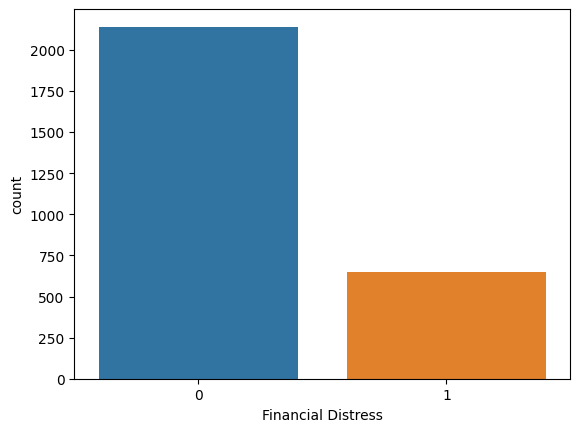

In [12]:
# countplot of the target variable
sns.countplot(x = df['Financial Distress']);

This shows that the target variable is imbalanced and it would restrict the models from learning patterns well from the other class. Hence, a good solution to this would be Oversampling of the minority class to enable the trained model make better predictions.

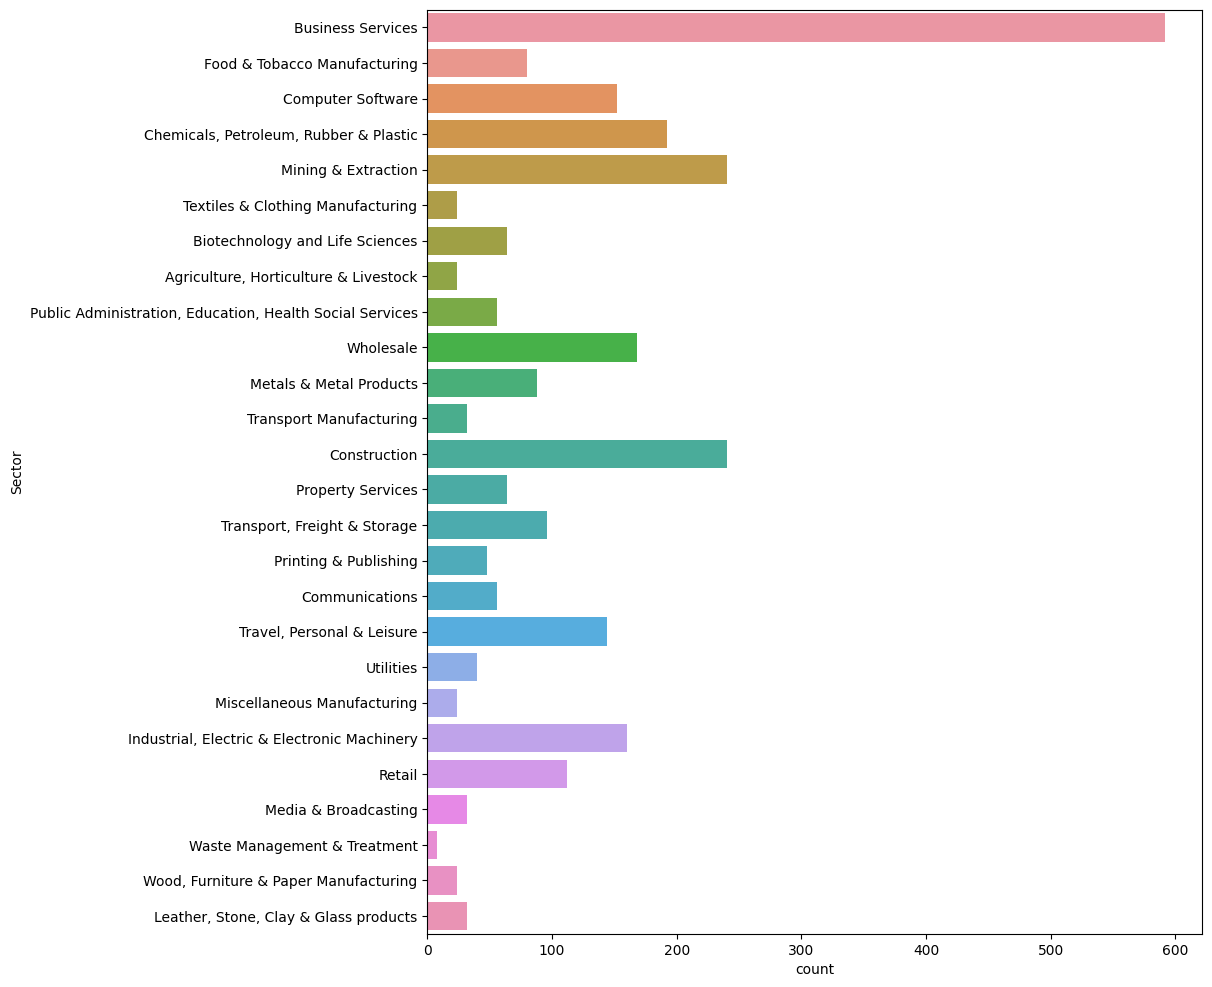

In [13]:
plt.figure(figsize = (10,12))
sns.countplot(y = df['Sector']);

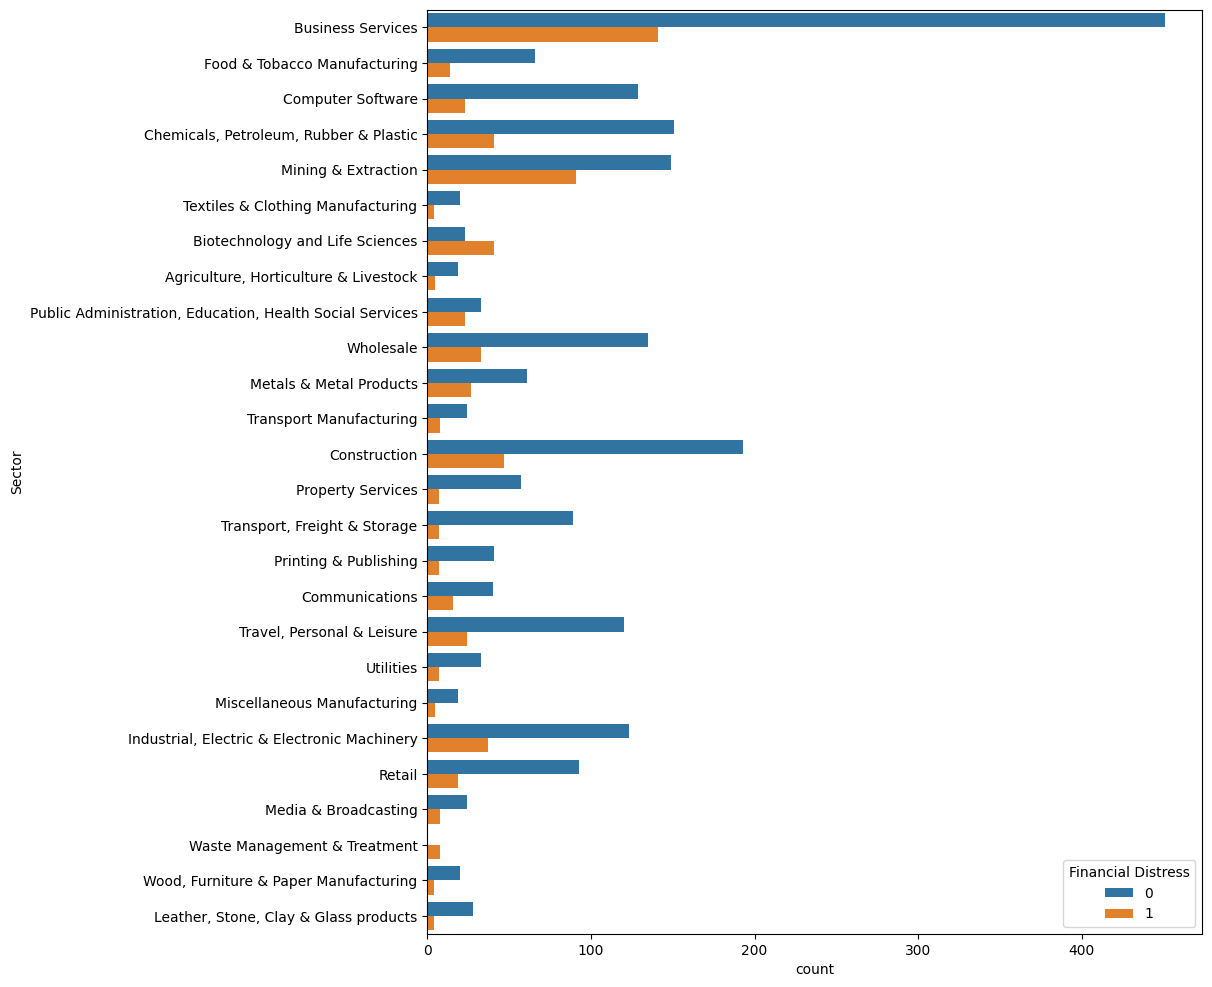

In [14]:
plt.figure(figsize = (10,12))
sns.countplot(y = df['Sector'], hue = df['Financial Distress']);

In [15]:
#group the df by Financial Distress and Year and find the count
grouped_counts_df = df.groupby(['Financial Distress'])['Year'].value_counts().unstack()

#add a column for row totals
grouped_counts_df['Total'] = grouped_counts_df.sum(axis=1)

#add a row for year totals
grouped_counts_df.loc['Total'] = grouped_counts_df.sum(axis=0)

#display the count of financial distress by year
display(grouped_counts_df)


Year,2015,2016,2017,2018,2019,2020,2021,2022,Total
Financial Distress,,,,,,,,,
0,260,281,279,265,248,217,297,294,2141
1,89,68,70,84,101,132,52,55,651
Total,349,349,349,349,349,349,349,349,2792


In [16]:
#group the df by Sector and Year and find the count
grouped_counts_df = df.groupby(['Sector'])['Year'].value_counts().unstack()

#add a column for sector totals
grouped_counts_df['Total'] = grouped_counts_df.sum(axis=1)

#create and display a dataframe showing company count in each year and in total, sorted by the total
grouped_counts_df = pd.DataFrame(grouped_counts_df).sort_values(by='Total', ascending=False).style.format('{:.0f}')
display(grouped_counts_df)

Year,2015,2016,2017,2018,2019,2020,2021,2022,Total
Sector,,,,,,,,,
Business Services,74,74,74,74,74,74,74,74,592
Mining & Extraction,30,30,30,30,30,30,30,30,240
Construction,30,30,30,30,30,30,30,30,240
"Chemicals, Petroleum, Rubber & Plastic",24,24,24,24,24,24,24,24,192
Wholesale,21,21,21,21,21,21,21,21,168
"Industrial, Electric & Electronic Machinery",20,20,20,20,20,20,20,20,160
Computer Software,19,19,19,19,19,19,19,19,152
"Travel, Personal & Leisure",18,18,18,18,18,18,18,18,144
Retail,14,14,14,14,14,14,14,14,112


## A Deeper look into the columns present.

Checking for skewness and outliers in the dataset by visualizations.

To avoid repetition of codes, Functions will be created for the visualizations of the distribution and boxplots across the columns in the dataset

In [17]:

def plot_dist_plots(dataframe):
    num_cols = len(dataframe.columns)
    num_rows = (num_cols // 4) + 1

    fig = plt.figure(figsize=(18, 12))
    fig.suptitle("Distribution Plots", fontsize='x-large', weight='extra bold', ha='center')

    for i, column in enumerate(dataframe.columns):
        plt.subplot(num_rows, 4, i+1)
        sns.distplot(dataframe[column], color='green')

    plt.tight_layout()
    plt.show()

def plot_box_plots(dataframe):
    num_cols = len(dataframe.columns)
    num_rows = (num_cols // 4) + 1

    fig = plt.figure(figsize=(18, 12))
    fig.suptitle("Box Plots", fontsize='x-large', weight='extra bold', ha='center')

    for i, column in enumerate(dataframe.columns):
        plt.subplot(num_rows, 4, i+1)
        sns.boxplot(dataframe[column], color='red')

    plt.tight_layout()
    plt.show()


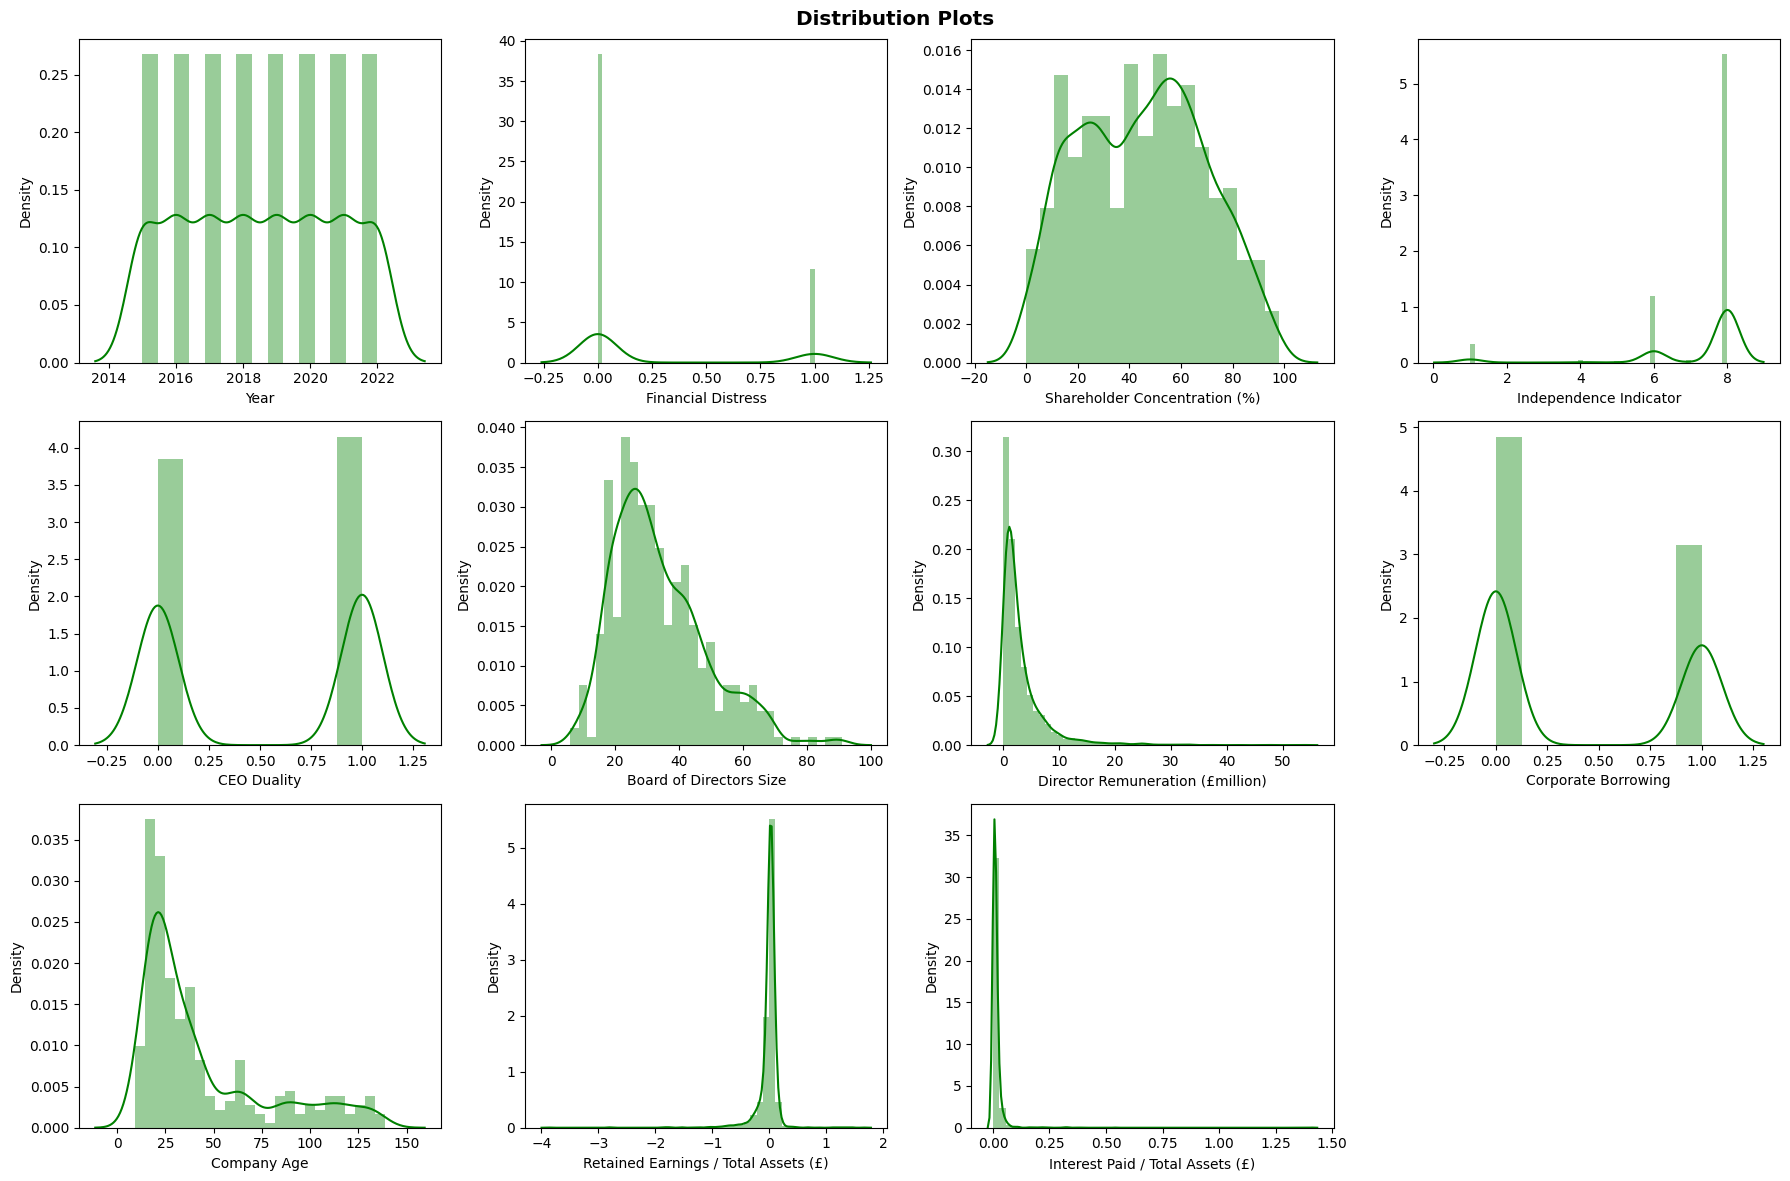

In [18]:
df_dist = df.drop(['Sector', 'Company Name', 'ID'], axis = 1)
plot_dist_plots(df_dist)

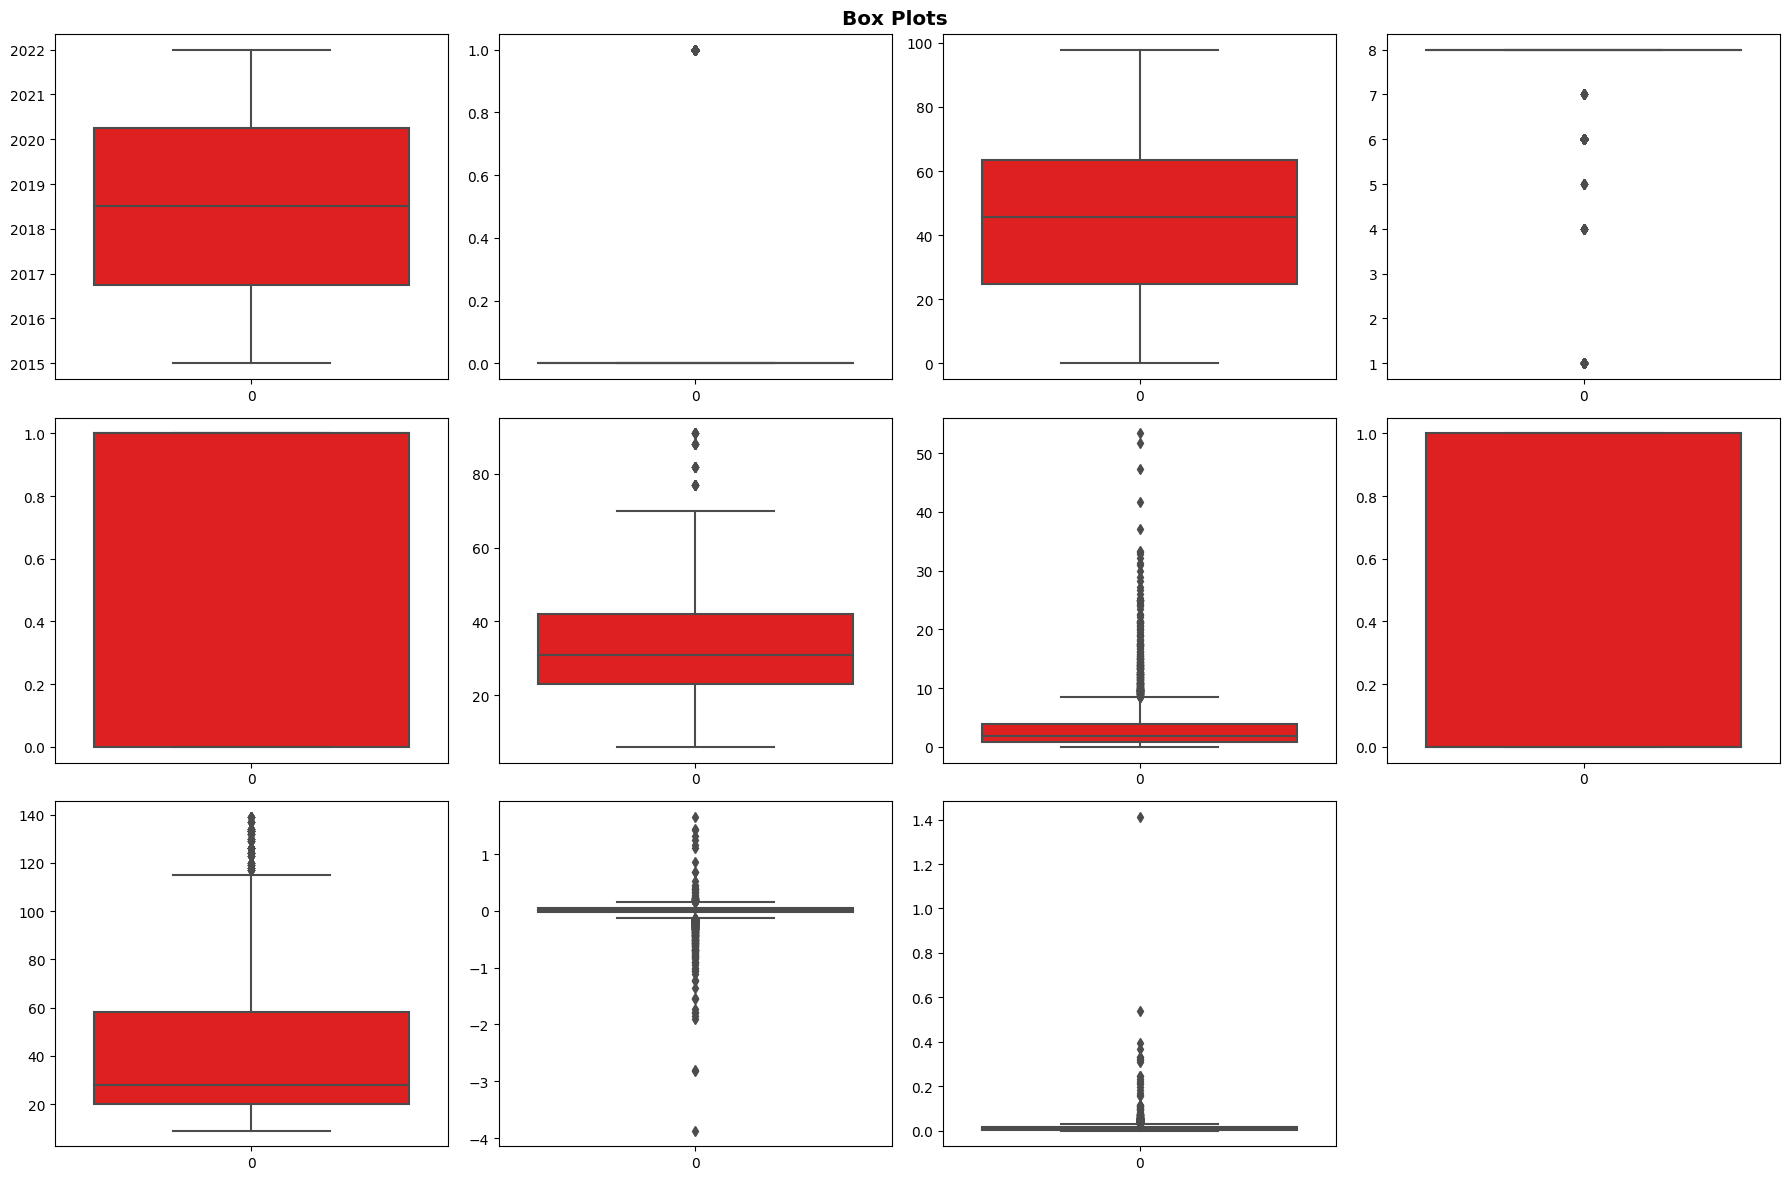

In [19]:
plot_box_plots(df_dist)

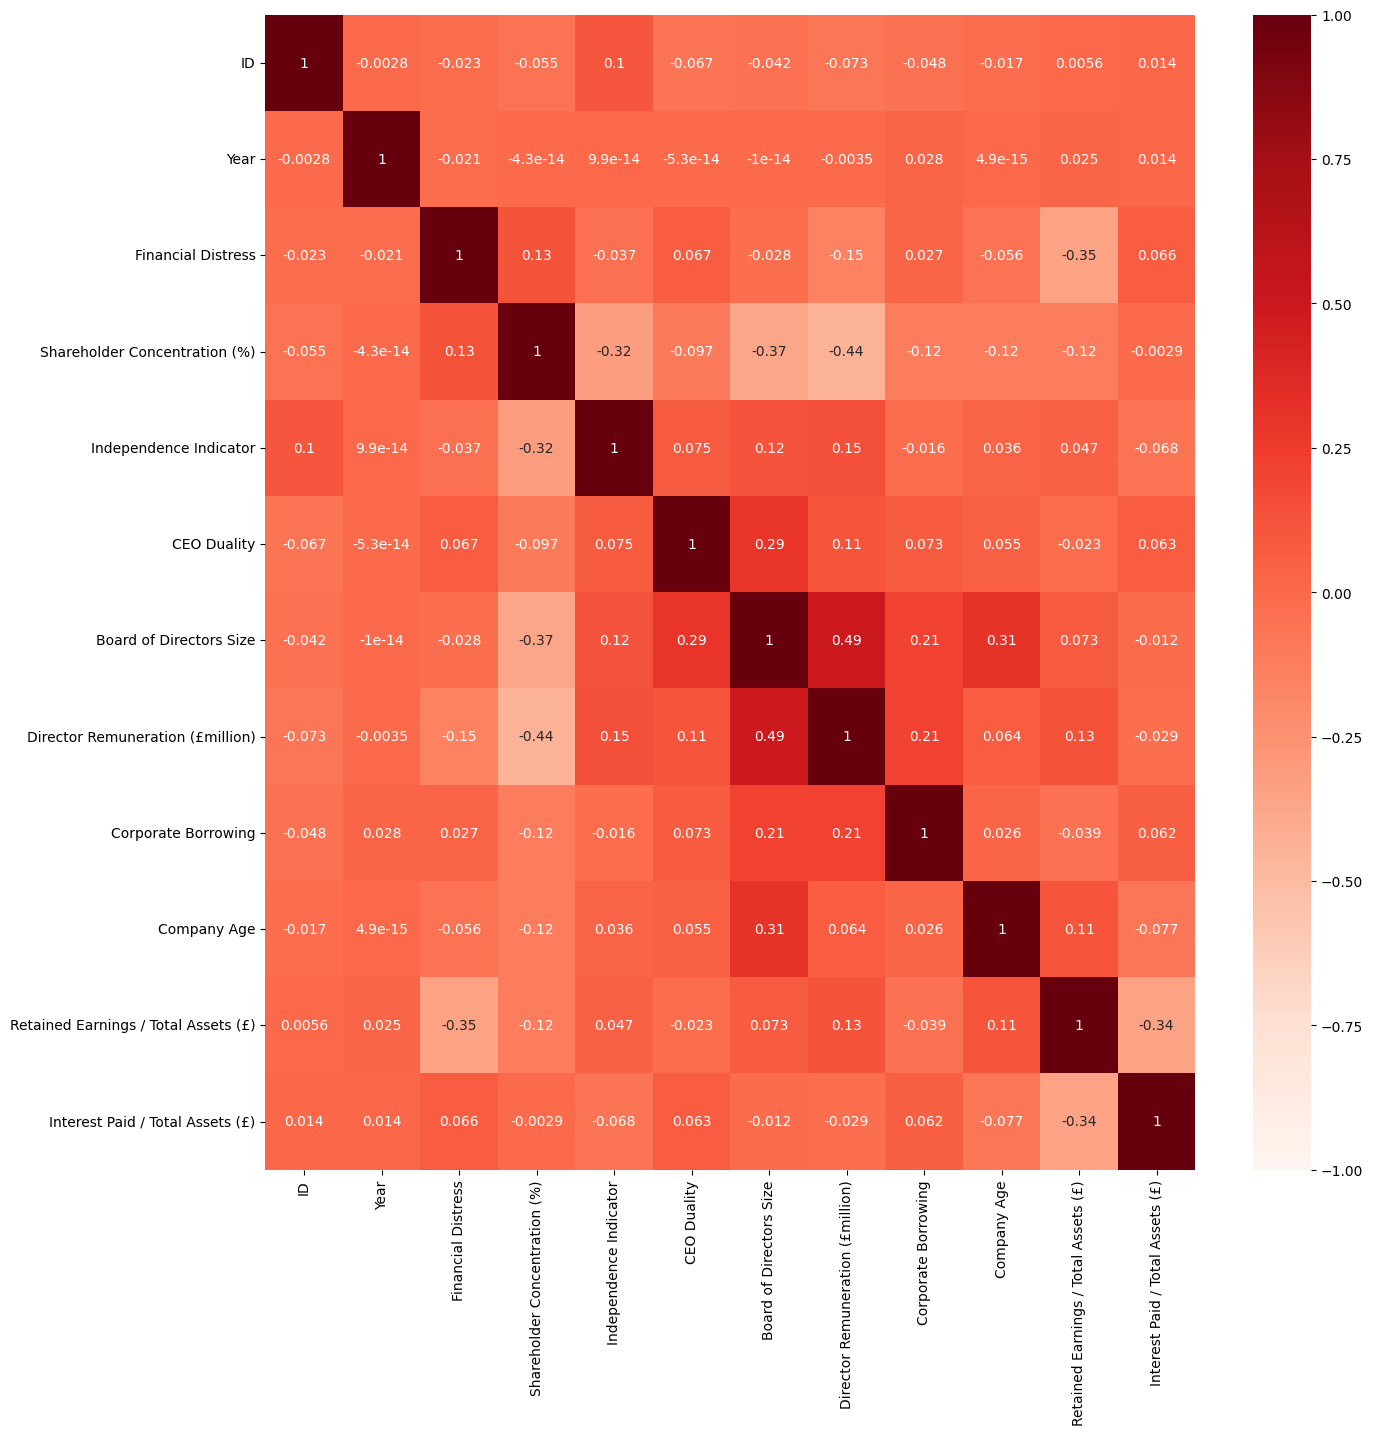

In [20]:
corr = df.corr()
ax, fig = plt.subplots(figsize=(15,15))
sns.heatmap(corr, vmin=-1, cmap='Reds', annot=True)
plt.show();

DATA PREPROCESSING

data is split into input and target variables before preprocessing to avoid data leakage when training machine learning model

In [21]:
#drop columns
df = df.drop(['Sector', 'Company Name', 'ID', 'Year'], axis = 1)

#split data into input and target variables
x = df.drop('Financial Distress', axis=1)
y = df['Financial Distress']

In [22]:
#Oversampling of the minority class in the target column

oversample = RandomOverSampler(sampling_strategy='not majority')
x_sampled, y_sampled = oversample.fit_resample(x, y)

x = x_sampled
y = y_sampled


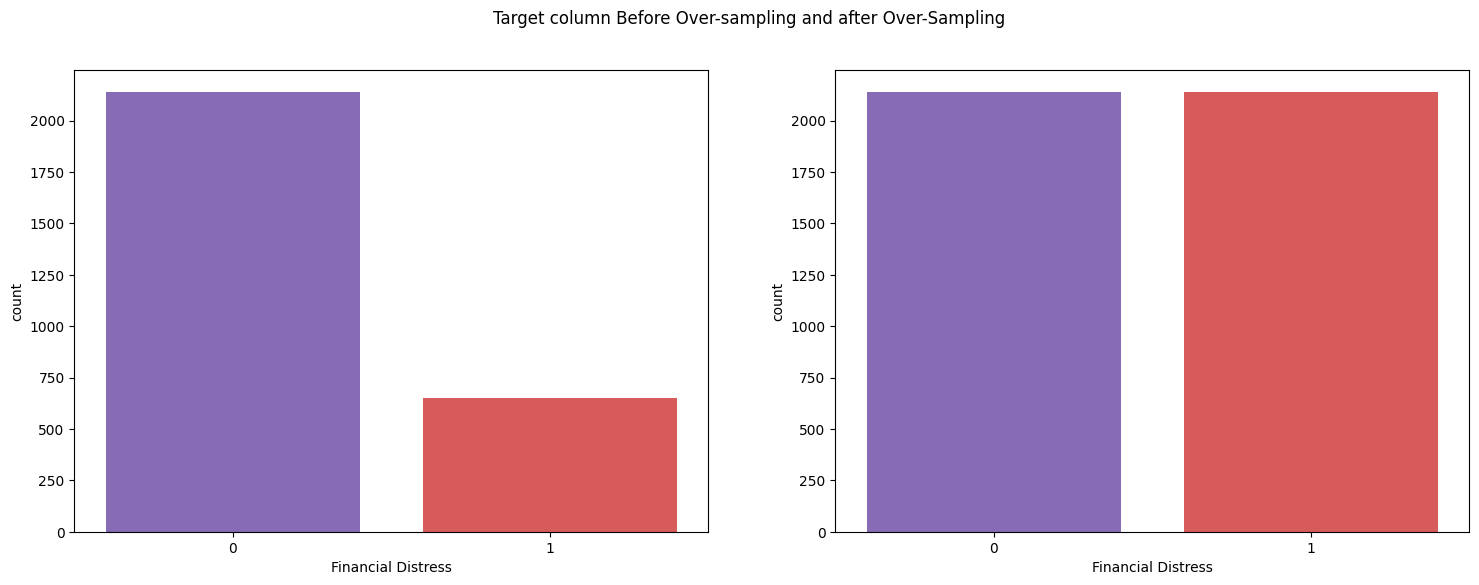

In [23]:
#visualize the oversampling results
plt.figure(figsize=(18,6))
plt.suptitle('Target column Before Over-sampling and after Over-Sampling')
plt.subplot(1,2,1)
sns.countplot(x = df['Financial Distress'], palette=['#845ec2','#ec4646','#00af91'])
plt.subplot(1,2,2)
sns.countplot(data=pd.DataFrame(y),x = 'Financial Distress', palette=['#845ec2','#ec4646','#00af91'] )
plt.show()

## FEATURE SCALING
Here the dataset is scaled using the Robust scaler.
The fit_transform is appropriately done on the training set and transform() on the test set.

But in this case, the target column contains categorical values, Categorical target columns represent discrete classes or categories, and they do not have a numerical relationship or magnitude that can be scaled using standard scaling. Hence, scaling would be done on the input variables alone.

In [24]:
#split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [25]:
# Create a RobustScaler object
scaler = RobustScaler()

# Fit and transform the scaler on the training data
x_train = scaler.fit_transform(x_train)

# Transform the testing data using the fitted scaler
x_test = scaler.transform(x_test)


# Convert the scaled arrays back to dataframes
x_train = pd.DataFrame(x_train, columns = x.columns)
x_test = pd.DataFrame(x_test, columns = x.columns)

In [26]:
x_train.head()

,Shareholder Concentration (%),Independence Indicator,CEO Duality,Board of Directors Size,Director Remuneration (£million),Corporate Borrowing,Company Age,Retained Earnings / Total Assets (£),Interest Paid / Total Assets (£)
0,0.284344,0.0,0.0,1.157895,0.329162,1.0,0.290323,-0.050888,0.360085
1,0.798341,0.0,-1.0,-0.263158,-0.131589,0.0,0.000000,-0.268630,0.169945
2,-0.007517,0.0,-1.0,0.368421,0.265832,0.0,0.322581,0.036661,0.054296
3,-0.783048,0.0,-1.0,-0.368421,-0.428896,0.0,-0.290323,-2.934941,-0.742104
4,-0.270347,0.0,-1.0,-0.105263,0.237391,0.0,-0.258065,0.003157,0.297126


In [27]:
y_train.head()

378     0
3345    1
678     0
3946    1
1515    0
Name: Financial Distress, dtype: int64

## MODEL TRAINING

MODELS TRAINED



*  LOGISTIC REGRESSION
*   RANDOM FOREST CLASSIFIER

*   SUPPORT VECTOR MACHINES
*   1-D CONVOLUTIONAL NEURAL NETWORK





### Model 1: Logistic Regression

In [28]:
#create an instance for the model
log_reg = LogisticRegression()
#fit model to training data
log_reg.fit(x_train, y_train)
log_reg_pred = log_reg.predict(x_test)
print(confusion_matrix(y_test, log_reg_pred))

[[547 114]
 [211 413]]


In [29]:
print(classification_report(y_test,log_reg_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       661
           1       0.78      0.66      0.72       624

    accuracy                           0.75      1285
   macro avg       0.75      0.74      0.74      1285
weighted avg       0.75      0.75      0.75      1285



### Model 2: Random Forest Classifier

In [30]:
#create an instance for the model
rfc_model = RandomForestClassifier()
#fit model to training data
rfc_model.fit(x_train, y_train)
#predict
rfc_pred = rfc_model.predict(x_test)

print(confusion_matrix(y_test, rfc_pred))

[[573  88]
 [ 32 592]]


In [31]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       661
           1       0.87      0.95      0.91       624

    accuracy                           0.91      1285
   macro avg       0.91      0.91      0.91      1285
weighted avg       0.91      0.91      0.91      1285



### Model 3 : Support Vector Classifier

In [32]:
#create an instance for the model
svc_model = SVC()
#fit model to training data
svc_model.fit(x_train, y_train)
svc_pred = svc_model.predict(x_test)
print(confusion_matrix(y_test, svc_pred))

[[559 102]
 [214 410]]


In [33]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       661
           1       0.80      0.66      0.72       624

    accuracy                           0.75      1285
   macro avg       0.76      0.75      0.75      1285
weighted avg       0.76      0.75      0.75      1285



### Model 4: Convolutional Neural Network

In [34]:

# Subtract 1 from the labels to align with zero-based indices
y_train_encoded = y_train - 1
y_test_encoded = y_test - 1

# Convert target labels to one-hot encoded format
y_train_encoded = to_categorical(y_train_encoded, num_classes=2)
y_test_encoded = to_categorical(y_test_encoded, num_classes=2)


In [35]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(9, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 50)                12850     
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 13,144
Trainable params: 13,144
Non-trainable params: 0
____________________________________________________

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(x_train,y_train_encoded, batch_size= 2, epochs= 10, verbose=1, validation_split = 0.3)

Epoch 1/10
1049/1049 [==============================] - 6s 4ms/step - loss: 0.5820 - accuracy: 0.7091 - val_loss: 0.5843 - val_accuracy: 0.7144
Epoch 2/10
1049/1049 [==============================] - 3s 3ms/step - loss: 0.5432 - accuracy: 0.7277 - val_loss: 0.5600 - val_accuracy: 0.7244
Epoch 3/10
1049/1049 [==============================] - 3s 3ms/step - loss: 0.5361 - accuracy: 0.7339 - val_loss: 0.5645 - val_accuracy: 0.7289
Epoch 4/10
1049/1049 [==============================] - 3s 3ms/step - loss: 0.5321 - accuracy: 0.7387 - val_loss: 0.5593 - val_accuracy: 0.7133
Epoch 5/10
1049/1049 [==============================] - 4s 4ms/step - loss: 0.5250 - accuracy: 0.7454 - val_loss: 0.5802 - val_accuracy: 0.6867
Epoch 6/10
1049/1049 [==============================] - 3s 3ms/step - loss: 0.5213 - accuracy: 0.7487 - val_loss: 0.5505 - val_accuracy: 0.7111
Epoch 7/10
1049/1049 [==============================] - 3s 3ms/step - loss: 0.5164 - accuracy: 0.7430 - val_loss: 0.5673 - val_accuracy:

In [37]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

41/41 [==============================] - 0s 3ms/step - loss: 0.5042 - accuracy: 0.7502
Test Loss: 0.5042204856872559
Test Accuracy: 0.7501945495605469


In [38]:

def plot_graph(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Adjust spacing between plots
    plt.tight_layout()

    # Show the plot
    plt.show()


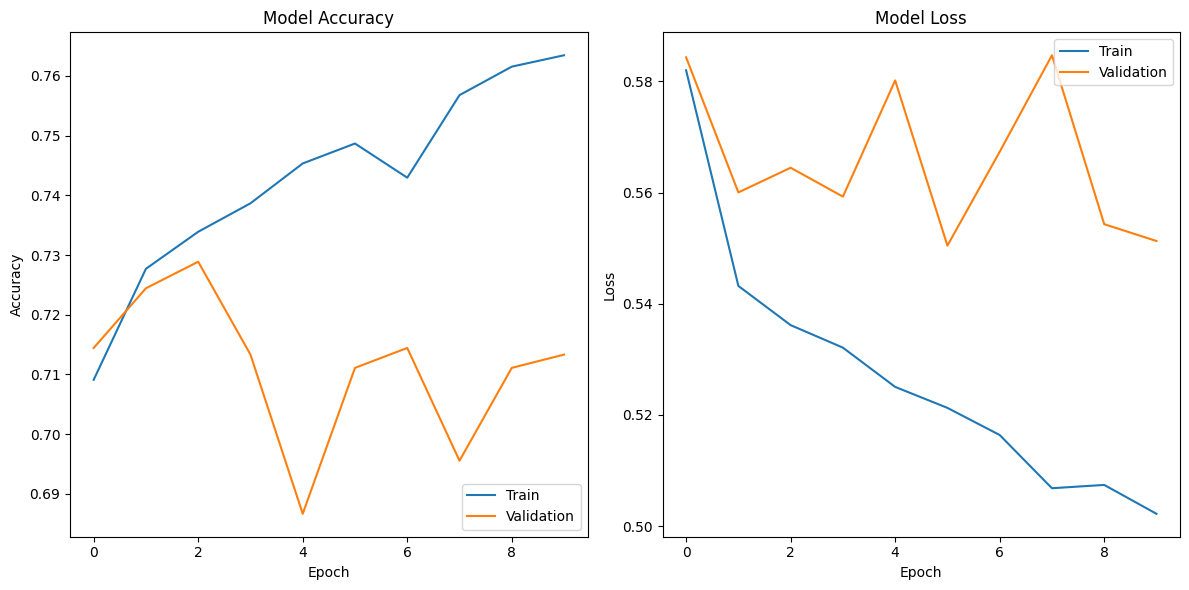

In [39]:
plot_graph(history)

## MODEL IMPROVEMENT AND OPTIMIZATION

LOGISTIC REGRESSION

In [48]:
# Grid search cross validation

param_grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg,param_grid = param_grid,cv=5)
grid_search.fit(x_train,y_train)

# Print the best hyperparameters and corresponding performance metric
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'C': 1.0, 'penalty': 'l2'}
Best Score:  0.730723427935448


In [49]:
# Train the final model with the best hyperparameters on the entire training data
log_reg_tuned = LogisticRegression(**grid_search.best_params_)
log_reg_tuned.fit(x_train, y_train)

#predict
log_reg_tuned_pred = log_reg_tuned.predict(x_test)

# Calculate and print the confusion matrix
print(confusion_matrix(y_test, log_reg_tuned_pred))

[[547 114]
 [211 413]]


In [50]:
print(classification_report(y_test, log_reg_tuned_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       661
           1       0.78      0.66      0.72       624

    accuracy                           0.75      1285
   macro avg       0.75      0.74      0.74      1285
weighted avg       0.75      0.75      0.75      1285



In [51]:
# Evaluate the final model on the test data
log_reg_accuracy = log_reg_tuned.score(x_test, y_test)
print("Test Accuracy after Tuning: ", log_reg_accuracy)

Test Accuracy after Tuning:  0.7470817120622568


RANDOM FOREST

In [53]:

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
}

# Create a random forest classifier
rf_classifier = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and corresponding performance metric
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score:  0.8842075681691709


In [54]:
# Train the final model with the best hyperparameters on the entire training data
rf_tuned = RandomForestClassifier(**grid_search.best_params_)
rf_tuned.fit(x_train, y_train)

#predict
rf_tuned_pred = rf_tuned.predict(x_test)

# Calculate and print the confusion matrix
print(confusion_matrix(y_test, rf_tuned_pred))

[[577  84]
 [ 32 592]]


In [55]:
print(classification_report(y_test, rf_tuned_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       661
           1       0.88      0.95      0.91       624

    accuracy                           0.91      1285
   macro avg       0.91      0.91      0.91      1285
weighted avg       0.91      0.91      0.91      1285



In [57]:
# Evaluate the final model on the test data
rf_accuracy = rf_tuned.score(x_test, y_test)
print("Test Accuracy after Tuning: ", rf_accuracy)

Test Accuracy after Tuning:  0.909727626459144


SUPPORT VECTOR MACHINES

In [40]:

# Define the hyperparameter grid

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

# Create a random forest classifier
svc_tuned = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator= svc_tuned, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and corresponding performance metric
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)




Best Hyperparameters:  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score:  0.7330550918196994


In [41]:
# Train the final model with the best hyperparameters on the entire training data
SVC_tuned = SVC(**grid_search.best_params_)
SVC_tuned.fit(x_train, y_train)

#predict
SVC_tuned_pred = SVC_tuned.predict(x_test)

# Calculate and print the confusion matrix
print(confusion_matrix(y_test, SVC_tuned_pred))

[[561 100]
 [218 406]]


In [42]:
print(classification_report(y_test, SVC_tuned_pred))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       661
           1       0.80      0.65      0.72       624

    accuracy                           0.75      1285
   macro avg       0.76      0.75      0.75      1285
weighted avg       0.76      0.75      0.75      1285



In [43]:
# Evaluate the final model on the test data
svc_accuracy = SVC_tuned.score(x_test, y_test)
print("Test Accuracy after Tuning: ", svc_accuracy)

Test Accuracy after Tuning:  0.7525291828793774


CONVOLUTIONAL NEURAL NETWORK

In [44]:

#define model architecture
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                            kernel_size=hp.Int('kernel_size', min_value=3, max_value=5),
                            activation='relu',
                            input_shape=(9, 1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

#state hyperparameters to tune
hp = HyperParameters()
hp.Int('filters', min_value=32, max_value=128, step=32)
hp.Int('kernel_size', min_value=3, max_value=5)
hp.Int('units', min_value=32, max_value=128, step=32)

#Define model-building function
class MyHyperModel(HyperModel):
    def build(self, hp):
        return build_model(hp)

#Define search space
hypermodel = MyHyperModel()

#Configure the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='my_project'
)

#Search for the best hyperparameters
tuner.search(x_train, y_train_encoded, epochs=10, validation_split=0.3)

#get best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

#Train a model with the best hyperparameters gotten
best_model = tuner.hypermodel.build(best_hyperparameters)
best_model_history = best_model.fit(x_train, y_train_encoded, epochs=10, validation_split=0.3)


Trial 10 Complete [00h 00m 06s]
val_accuracy: 0.7300000190734863

Best val_accuracy So Far: 0.7300000190734863
Total elapsed time: 00h 01m 00s
Epoch 1/10
66/66 [==============================] - 1s 7ms/step - loss: 0.5984 - accuracy: 0.6905 - val_loss: 0.5640 - val_accuracy: 0.7089
Epoch 2/10
66/66 [==============================] - 0s 4ms/step - loss: 0.5505 - accuracy: 0.7287 - val_loss: 0.5564 - val_accuracy: 0.7100
Epoch 3/10
66/66 [==============================] - 0s 4ms/step - loss: 0.5373 - accuracy: 0.7287 - val_loss: 0.5540 - val_accuracy: 0.7144
Epoch 4/10
66/66 [==============================] - 0s 4ms/step - loss: 0.5326 - accuracy: 0.7372 - val_loss: 0.5740 - val_accuracy: 0.7067
Epoch 5/10
66/66 [==============================] - 0s 4ms/step - loss: 0.5194 - accuracy: 0.7458 - val_loss: 0.5532 - val_accuracy: 0.6967
Epoch 6/10
66/66 [==============================] - 0s 4ms/step - loss: 0.5179 - accuracy: 0.7458 - val_loss: 0.5522 - val_accuracy: 0.7044
Epoch 7/10
66/66 

In [45]:
# Evaluate trained model on the test data
cnn_loss, cnn_accuracy = best_model.evaluate(x_test, y_test_encoded)
print("Test Loss:", cnn_loss)
print("Test Accuracy:", cnn_accuracy)

41/41 [==============================] - 0s 2ms/step - loss: 0.5260 - accuracy: 0.7510
Test Loss: 0.5260285139083862
Test Accuracy: 0.7509727478027344


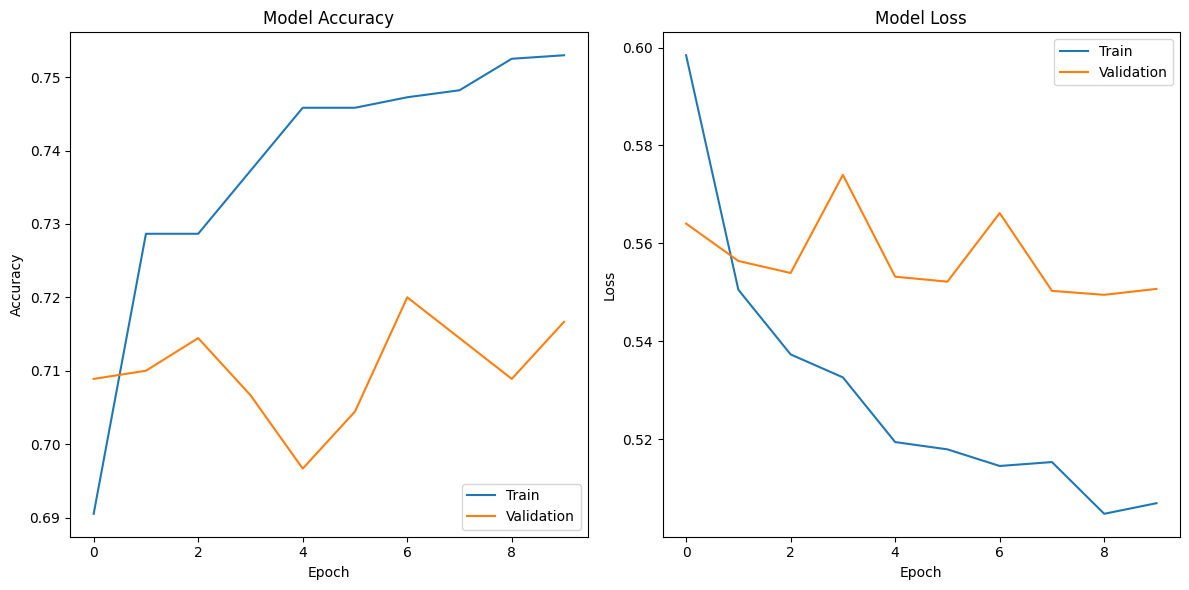

In [46]:
plot_graph(best_model_history)

OVERALL MODEL METRICS AFTER TUNING OF HYPER PARAMETERS

In [58]:
#create a dictionary for the models and accuracies
model_df = {
    'Model': [
    'Logistic Regression',
    'Random Forest Classifier',
    'Support Vector Classifier',
    '1-D Convolutional Neural Network',
    ],

    'Accuracy(%)': [
        f"{log_reg_accuracy*100:.2f}",
        f"{rf_accuracy*100:.2f}",
        f"{svc_accuracy*100:.2f}",
        f"{cnn_accuracy*100:.2f}",
        ]
}


#create a dataframe from the dictionary
evaluation_metrics = pd.DataFrame(model_df)

evaluation_metrics



,Model,Accuracy(%)
0,Logistic Regression,74.71
1,Random Forest Classifier,90.97
2,Support Vector Classifier,75.25
3,1-D Convolutional Neural Network,75.10


In [59]:
# Convert the 'Accuracy(%)' column to float
evaluation_metrics['Accuracy(%)'] = evaluation_metrics['Accuracy(%)'].astype(float)

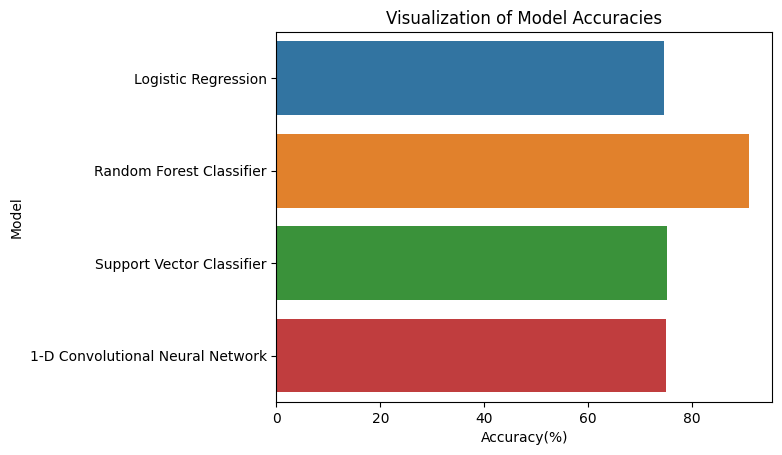

In [60]:
# Plot the model accuracies using a bar plot
sns.barplot(x='Accuracy(%)', y='Model', data=evaluation_metrics)

# Add labels and title
plt.xlabel('Accuracy(%)')
plt.ylabel('Model')
plt.title('Visualization of Model Accuracies')

# Show the plot
plt.show()